## Title: Predicting Heart Disease

### Introduction:
Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
Clearly state the question you will try to answer with your project
Identify and describe the dataset that will be used to answer the question
 

Heart disease is an umbrella term for a vast range of conditions that affect the heart. Stroke, heart attack, cardiomyopathy, and angina are all 
examples of heart disease. Leading risk factors for heart disease are high blood pressure and cholesterol, obesity, unhealthy diet, and physical inactivity.
Based on a dataset from 1988 consisting of 4 databases, Cleveland, Hungary, Switzerland, and Long Beach V, heart disease could be predicted 
in a patient by looking at 14 attributes. Of these attributes, 5 will be observed in order to successfully determine the presence of heart disease
in a patient. The predictive question being asked is, "By considering age, exercise induced angina, serum cholesterol levels, and resting blood pressure, can heart disease in a patient be predicted?". It is important 
to answer this question because heart disease is evidently fatal, and an early diagnosis increases the chances of recovery and/or 
survival. Though treatment varies based on the type and cause of the disease, changes in lifestyle and habits can influence the risk of heart disease significantly.
Recognizing the possibility of heart disease early on is important for patients, and thus, this project will allow for recognition of patterns seen in the five variables that may indicate the possibility of heart disease in younger patients.

### Preliminary Exploratory Data Analysis:


Demonstrate that the dataset can be read from the web into R 
Clean and wrangle your data into a tidy format
Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

We first started by reading in the heart data, and selecting the predictors we wanted use.

In [71]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
library(ggplot2)


heart_data <- read_csv("project_data/heart.csv")

heart_var <- heart_data |>
    select(age, exang, chol, cp, trestbps, target)
slice(heart_var, 1:5)

cp_numbers <- sum(cp==3)



Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,exang,chol,cp,trestbps,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,0,212,0,125,0
53,1,203,0,140,0
70,1,174,0,145,0
61,0,203,0,148,0
62,0,294,0,138,0


ERROR: Error in eval(expr, envir, enclos): object 'cp' not found


We split the data with the variables we selected into a training set with 75% of the data, and a test set ith 25% of the data. To see some of the data, we used the slice function to show the first five rows. Then, we checked if there were any rows with missing data which there were not.

In [142]:
set.seed(3456)

heart_split <- initial_split(heart_var, prop = 0.75, strata = target)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

slice(heart_train, 1:5)

cp_val <- heart_train |>
  group_by(cp)|>
  summarise(counts = n())


exang_val <- heart_train |>
   group_by(exang)|>
   summarise(counts=n())


chol_val <- heart_train |>
   group_by(chol)


age,exang,chol,cp,trestbps,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
53,1,203,0,140,0
70,1,174,0,145,0
61,0,203,0,148,0
46,0,249,0,120,0
43,1,341,0,132,0


From here we began to look at each variable and if there were any trends that could be seen. The "target" variable shows whether each person has heart disease which is indicated with a 1, or if they do not have heart disease, 0. Using the "sum" function above, we checked for any missing data and found that we are working witha full set. To get a better idea of the data we are working with, we visualized the training data into various scatter plot graphs with "target" showing heart disease on the x-axis, and the other predictors on the y-axis on separate plots. 

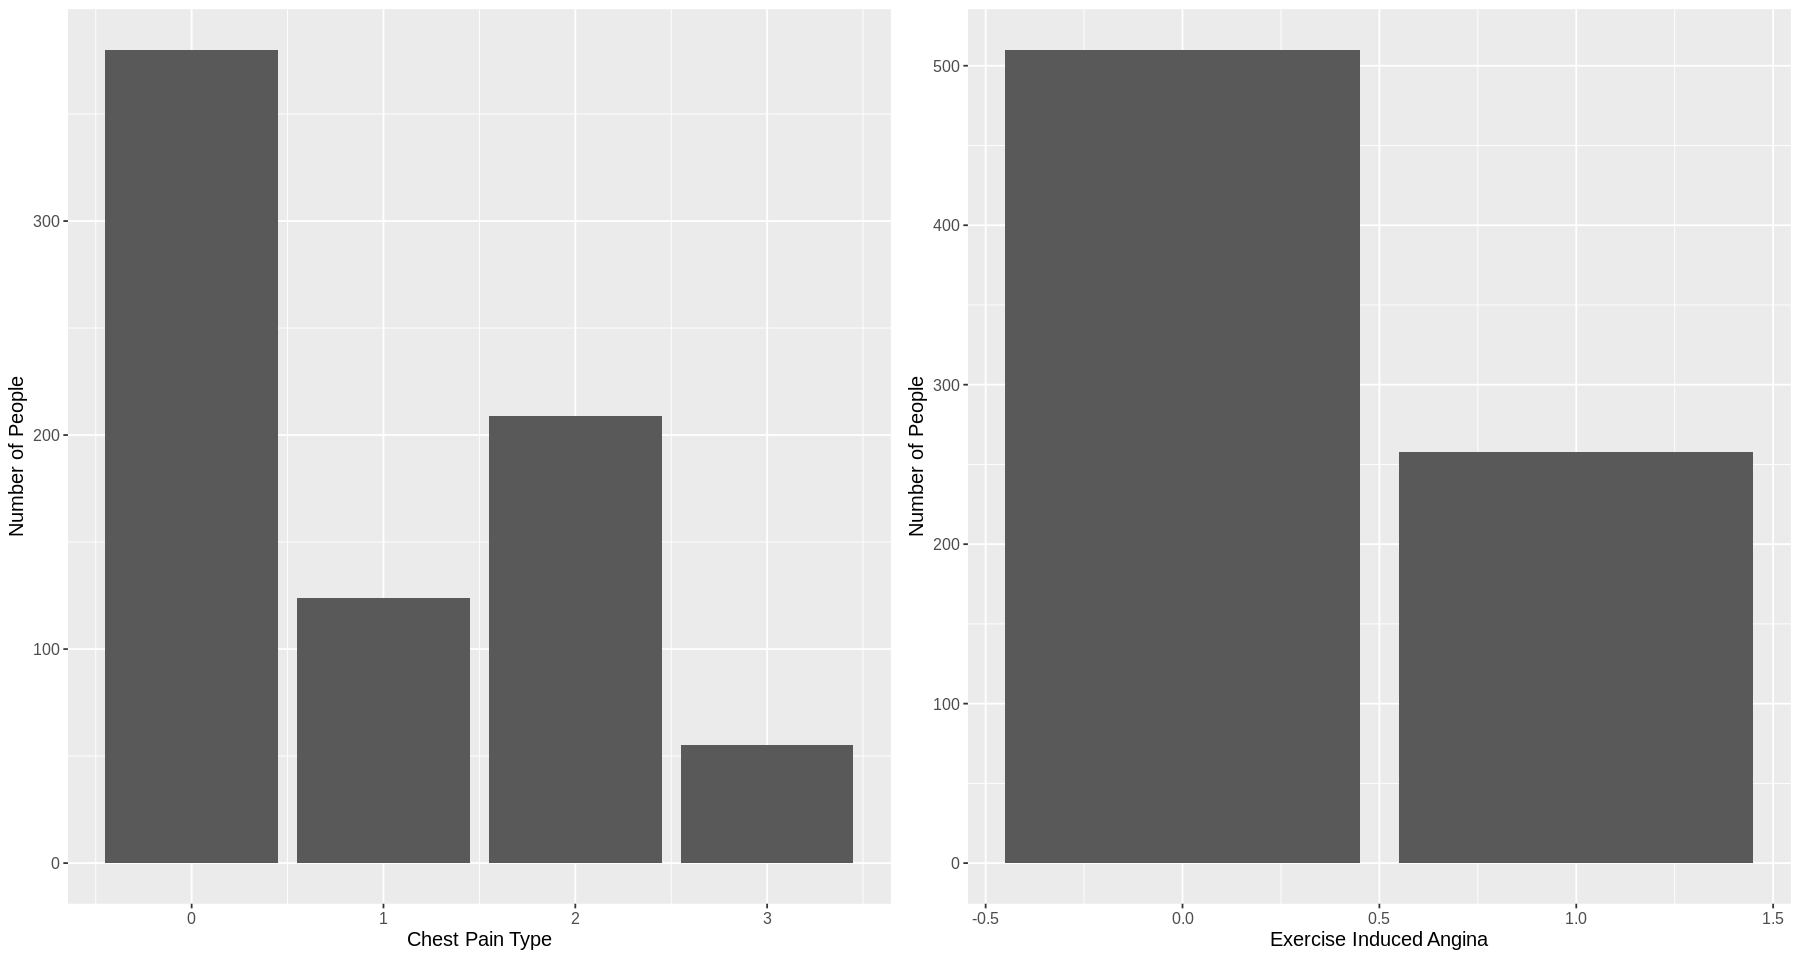

In [139]:
options(repr.plot.width = 15, repr.plot.height = 8)

cp_plot <- ggplot(cp_val, aes(x = cp, y = counts)) +
  geom_bar(stat = "identity")+
  labs(x = "Chest Pain Type", y = "Number of People") +
  theme(text = element_text(size = 12))


exang_plot <- ggplot(exang_val, aes(x = exang, y = counts)) +
  geom_bar(stat = "identity")+
  labs(x = "Exercise Induced Angina", y = "Number of People") +
  theme(text = element_text(size = 12))

require(gridExtra)
plot1 <- qplot(1)
plot2 <- qplot(1)
grid.arrange(cp_plot, exang_plot, ncol=2)

#chol_plot <- ggplot(heart_train, 
       #aes(y = chol, 
           #x =as.factor(target))) +
        geom_boxplot(fill="slateblue", alpha=0.2)+
        labs(x="Presence of Heart Disease (0=no, 1=yes)", y="Cholesteral Level" )


trestbps_plot<- ggplot(heart_train,
        aes(y= trestbps,
            x= as.factor(target))) +
    geom_boxplot(fill="red", alpha=0.2)+
    labs(x="Presence of Heart Disease (0=no, 1=yes)", y="Resting Blood Pressure" )
        

#age_plot<- ggplot(heart_train,
        #aes(y= age,
            #x= as.factor(target))) +
    #geom_boxplot(fill="purple", alpha=0.2)+
    #labs(x="Presence of Heart Disease (0=no, 1=yes)", y="Age" )
       


#cp_plot <-ggplot(data= heart_train, aes(x=target, y=cp,fill=group)) +
  #geom_bar()


### Methods:
Explain how you will conduct either your data analysis and which variables/columns you will use. 
Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good 
idea. For each variable think: is this a useful variable for prediction?
Describe at least one way that you will visualize the results

To predict whether a patient has heart disease, a classifier needs to be taught and trained. This is to increase the accuracy
of the classifier. The data will be split into a training set and a testing set in order to build an efficient and accurate model
by first using only the training set. This will ensure that the test data does not influence the classifier model being trained.
Because the K-nearest neighbors classification algorithm will be used, the value of K to be used must be determined. Performing 
v-fold cross-validation will determine this. The K value that yields roughly the optimal accuracy, and the value that does not drastically 
change the estimated accuracy when decreasing or increasing K by a small amount will be the best option. Now, the K-nearest neighbors 
classifier object will be used to predict the class labels of the test set and predict whether there is a presence of heart disease in the 
patient. The patient will be evaluated with an integer value of 0 or 1 in the "target" field; 0 = no disease; 1 = disease.
The variables considered in the data analysis will be: age, exercise induced angina, serum cholesterol levels, chest pain, and resting blood pressure. 

Generally, as age increases, the risk of heart disease also increases. Angina is a type of chest pain that is often associated with different types of heart disease with one being coronary artery disease (Mayo Clinic Staff, 2022). According to Medical New Today, a persons serum cholesterol level can indicated their risks of developing heart disease, making it a good variable to explore (Jennifer Huizen , 2021). Lastly, we wanted to look at resting blood pressure as, risks of heart disease tend to increase in people with higher resting blood pressures (Joseph A. Hill, M.D., Ph.D., 2016).

### Expected outcomes and significance:
What do you expect to find?
What impact could such findings have?
What future questions could this lead to?

### Bibliography:

Mayo Foundation for Medical Education and Research. (2022, March 30). Angina. Mayo Clinic. Retrieved March 9, 2023, from https://www.mayoclinic.org/diseases-conditions/angina/symptoms-causes/syc-20369373#:~:text=Angina%20(an%2DJIE%2Dnuh,or%20pain%20in%20the%20chest. 

MediLexicon International. (n.d.). Serum cholesterol: What to know and how to manage levels. Medical News Today. Retrieved March 9, 2023, from https://www.medicalnewstoday.com/articles/321519#:~:text=A%20person's%20serum%20cholesterol%20level,of%20fat%20bundled%20with%20cholesterol. 

Under pressure: How blood pressure affects heart disease risk: Heart: UT southwestern medical center. Heart | UT Southwestern Medical Center. (n.d.). Retrieved March 9, 2023, from https://utswmed.org/medblog/high-blood-pressure-heart-disease/#:~:text=For%20the%20average%20person%20who,at%20risk%20for%20heart%20disease. 